In [1]:
import os
import jax
#
import elisa
from elisa.data.ogip import Data
from elisa.infer.fit import Fit, BayesFit, MaxLikeFit, MLEResult, PosteriorResult
from elisa.models import *
#
path = '/mnt/c/Users/steph/OneDrive/CCNU/SGR-RadiMechan/Data/gbm/bn20210129_070000'
os.chdir(path)
n5 = Data( ( (8.0,30.0) , (40.0,200.0) ), 'glg_tte_n5_bn20210129_070000.FITS',
          'glg_tte_n5_bn20210129_070000.BAK', 'glg_cspec_n5_bn20210129_070000.rsp',
          group='opt',
          )

n2 = Data( ( (8.0,30.0) , (40.0,200.0) ), 'glg_tte_n2_bn20210129_070000.FITS',
          'glg_tte_n2_bn20210129_070000.BAK', 'glg_cspec_n2_bn20210129_070000.rsp',
          group='opt',
          )
# 
datas = [n5, n2]
model_object = BlackbodyRad()

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
mle_object = MaxLikeFit(datas, model_object)
mle_result = mle_object.mle()
# 
baye_object = BayesFit(datas, model_object)
pos_result = baye_object.nuts()

Warming up


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [4]:
def plot_Fv(result, ax):
    mle_params = {k: v[0] for k, v in result.mle.items()}
    # 
    if isinstance(result, MLEResult):
        model_values = result._model_values
    if isinstance(result, PosteriorResult):
        model_values = result._mle_result['models']
    # 
    for k, v in result._helper.data.items():
        compiled = result._helper.model[k]
        ne_fn = jax.jit(
            lambda emin, emax, params: compiled.flux(emin, emax, params, energy=False)
        )
        Fv_fn = jax.jit(
            lambda emin, emax, params: ne_fn(emin, emax, params) * (emin * emax)**0.5 / (emax - emin) * 1.602176634e-9
        )
        Fv = jax.vmap(Fv_fn, in_axes=[0, 0, None])(v.channel_emin, v.channel_emax, mle_params)
        f = Fv / model_values[k]
        unfolded_Fv = v.ce * f
        err = v.ce_errors * f
        ax.errorbar(
            v.channel_emean, unfolded_Fv, err, v.channel_errors,
            fmt=f'{result.plot._markers[k]} ', label=k, color=result.plot.colors[k], mfc='#FFFFFFCC',
            mec=result.plot.colors[k], lw=0.75, ms=2.4, alpha=result.plot.config.alpha
        )
    ax.legend()

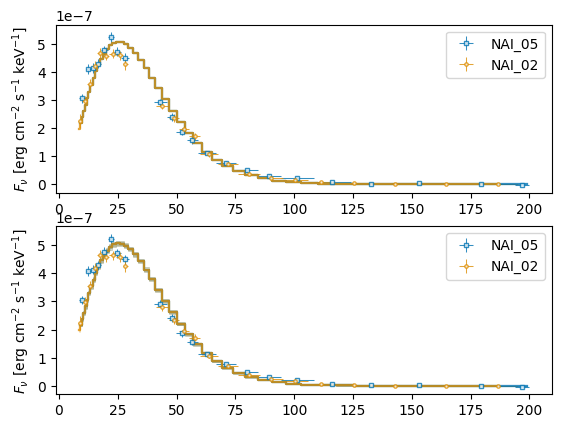

In [5]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,1)
plot_Fv(mle_result, axs[0])
mle_result.plot.plot_unfolded(axs[0], mtype='ene', label_Fv=True)
plot_Fv(pos_result, axs[1])
pos_result.plot.plot_unfolded(axs[1], mtype='ene', label_Fv=True)

In [6]:
def plot_vFv(result, ax):
    mle_params = {k: v[0] for k, v in result.mle.items()}
    # 
    if isinstance(result, MLEResult):
        model_values = result._model_values
    if isinstance(result, PosteriorResult):
        model_values = result._mle_result['models']
    # 
    for k, v in result._helper.data.items():
        compiled = result._helper.model[k]
        ne_fn = jax.jit(
            lambda emin, emax, params: compiled.flux(emin, emax, params, energy=False)
        )
        vFv_fn = jax.jit(
            lambda emin, emax, params: ne_fn(emin, emax, params) * (emin * emax) / (emax - emin) * 1.602176634e-9
        )
        vFv = jax.vmap(vFv_fn, in_axes=[0, 0, None])(v.channel_emin, v.channel_emax, mle_params)
        f = vFv / model_values[k]
        unfolded_vFv = v.ce * f
        err = v.ce_errors * f
        ax.errorbar(
            v.channel_emean, unfolded_vFv, err, v.channel_errors,
            fmt=f'{result.plot._markers[k]} ', label=k, color=result.plot.colors[k], mfc='#FFFFFFCC',
            mec=result.plot.colors[k], lw=0.75, ms=2.4, alpha=result.plot.config.alpha
        )
    ax.legend()

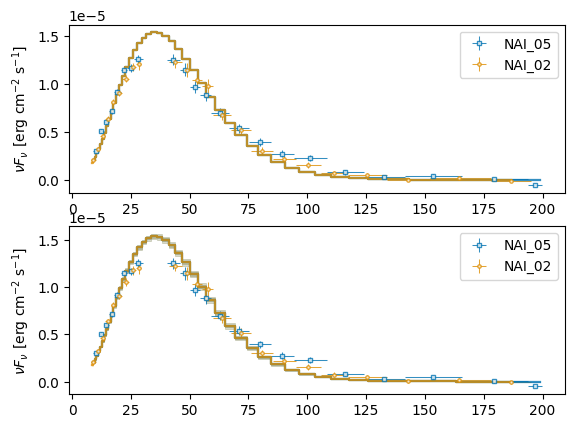

In [7]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,1)
plot_vFv(mle_result, axs[0])
mle_result.plot.plot_unfolded(axs[0], mtype='eene', label_vFv=True)
plot_vFv(pos_result, axs[1])
pos_result.plot.plot_unfolded(axs[1], mtype='eene', label_vFv=True)